In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# VGG16
from keras.applications.vgg16 import VGG16

# To show images
from PIL import Image

In [4]:
# Collect all data into one dataframe
def create_df(dataset):
    image_paths, labels = [], []

    for dirpath, dirnames, filenames in os.walk(dataset):
        for filename in filenames:

            image = os.path.join(dirpath, filename)
            image_paths.append(image)
            if dirpath[-3:] == 'all':
                labels.append('all')
            else:
                labels.append('hem')

    df = pd.DataFrame({'Image Path': image_paths,
                           'Label': labels})

    return df


# train_dir = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data"
# train_dir = "/content/drive/MyDrive/Datasets/C-NMC_Leukemia/training_data"
train_dir = "/kaggle/input/leukemia-classification/C-NMC_Leukemia/training_data"


df =  create_df(train_dir)

train_df, remaining_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=31, stratify=df['Label'])
valid_df, test_df= train_test_split(remaining_df, train_size=0.5, shuffle=True, random_state=31, stratify=remaining_df['Label'])

print("Number of training samples: %d" % len(train_df.index))
print("Number of test samples: %d" % len(test_df.index))
print("Number of validation samples: %d" % len(valid_df.index))

Number of training samples: 7462
Number of test samples: 1600
Number of validation samples: 1599


In [5]:
def show_history_plot(history):

    training_accuracy = history['accuracy']
    epochs = range(1, len(training_accuracy) + 1)

    # Creating subplots for accuracy and loss
    plt.figure(figsize=(15, 5))

    # Plotting training and validation accuracy
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
    plt.plot(epochs, history['accuracy'], 'b', label='Training accuracy', marker='o')
    plt.plot(epochs, history['val_accuracy'], 'c', label='Validation accuracy', marker='o')
    plt.title('Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
    plt.plot(epochs, history['loss'], 'b', label='Training loss', marker='o')
    plt.plot(epochs, history['val_loss'], 'c', label='Validation loss', marker='o')
    plt.title('Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Loss', fontsize=12)
    plt.legend()
    plt.grid(True)

    # Improve layout and displaying the plot
    plt.tight_layout()
    plt.show()

In [6]:
def show_conf_matrix(model):
    test_gen.reset()  # Reset the generator to be sure it's at the start of the dataset
    y_pred = model.predict(test_gen, steps=test_gen.n // test_gen.batch_size+1, verbose=0)

    label_dict = test_gen.class_indices
    classes = list(label_dict.keys())

    # Convert predictions to labels
    pred_labels = np.argmax(y_pred, axis=1)
    y_true = test_gen.classes

    # Generate the confusion matrix
    confusion_matrix = metrics.confusion_matrix(y_true, pred_labels)
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix, display_labels=[False, True])

    # Plot the confusion matrix
    cmap = plt.cm.Blues
    cm_display.plot(cmap=cmap, colorbar=False)

    plt.title('Confusion Matrix', fontsize=16)
    plt.figure(figsize=(7, 7))
    plt.show()

In [7]:
def evaluation_matrix(model):
    test_steps = len(test_df) // batch_size
    train_score = model.evaluate(train_gen, steps= test_steps, verbose= 0)
    valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 0)
    test_score = model.evaluate(test_gen, steps= test_steps, verbose= 0)

    header = "{:<12} {:<10} {:<10}".format("", "Loss", "Accuracy")
    separator = '-' * len(header)
    train_row = "{:<12} {:<10.5f} {:<10.5f}".format("Train", train_score[0], train_score[1])  # Formats the float to five decimal places
    valid_row = "{:<12} {:<10.5f} {:<10.5f}".format("Validation", valid_score[0], valid_score[1])
    test_row = "{:<12} {:<10.5f} {:<10.5f}".format("Test", test_score[0], test_score[1])

    table = '\n'.join([header, separator, train_row, valid_row, test_row])
    print(table)

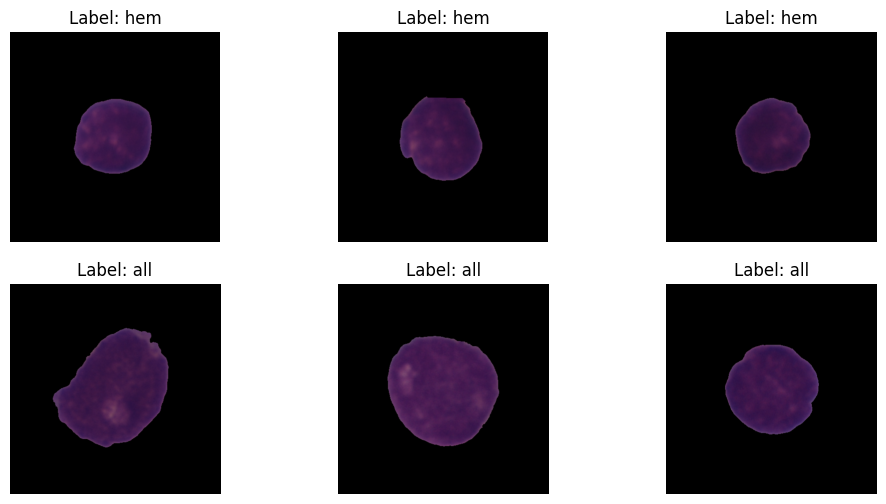

In [8]:
hem_img = train_df[train_df['Label'] == 'hem'].sample(3)
all_img = train_df[train_df['Label'] == 'all'].sample(3)
sampled_df = pd.concat([hem_img, all_img])

# Create a figure with subplots to show the images in
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

for i, row in enumerate(sampled_df.iterrows()):
    img = mpimg.imread(row[1]['Image Path'])
    ax = axes[i//3, i%3]
    ax.imshow(img)
    ax.axis('off')
    if row[1]['Label'] == 'hem':
        ax.set_title(f"Label: hem")
    else:
        ax.set_title(f"Label: all")

plt.show()

In [9]:
batch_size = 40

train_data_generator = ImageDataGenerator(horizontal_flip=True)
valid_data_generator = ImageDataGenerator()

train_gen = train_data_generator.flow_from_dataframe( train_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

valid_gen = valid_data_generator.flow_from_dataframe( valid_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = valid_data_generator.flow_from_dataframe( test_df, x_col= 'Image Path', y_col= 'Label', target_size= (224, 224), class_mode= 'categorical',
                                    color_mode= 'rgb', shuffle= False, batch_size= batch_size)

train_steps = test_gen.n // test_gen.batch_size + 1
validation_steps = valid_gen.n // valid_gen.batch_size

Found 7462 validated image filenames belonging to 2 classes.
Found 1599 validated image filenames belonging to 2 classes.
Found 1600 validated image filenames belonging to 2 classes.


In [10]:
# Create Model Structure
img_shape = (224, 224, 3)
EN3_base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

EN3_model = Sequential([
    EN3_base_model,
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.45),
    Dense(2, activation='softmax')
])

# Compile the model
EN3_model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

EN3_model.summary()

43941136/43941136 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                         

In [ ]:
epochs = 6

history_EN3 = EN3_model.fit(x= train_gen, epochs= epochs, verbose= 1,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Epoch 1/6
187/187 [==============================] - 2690s 14s/step - loss: 0.5687 - accuracy: 0.7967 - val_loss: 0.9482 - val_accuracy: 0.7655
Epoch 2/6
187/187 [==============================] - 2693s 14s/step - loss: 0.3055 - accuracy: 0.8823 - val_loss: 0.2593 - val_accuracy: 0.8981
Epoch 3/6
187/187 [==============================] - 2702s 14s/step - loss: 0.2430 - accuracy: 0.9071 - val_loss: 0.2798 - val_accuracy: 0.8843
Epoch 4/6
 84/187 [============>.................] - ETA: 24:07 - loss: 0.1976 - accuracy: 0.9220

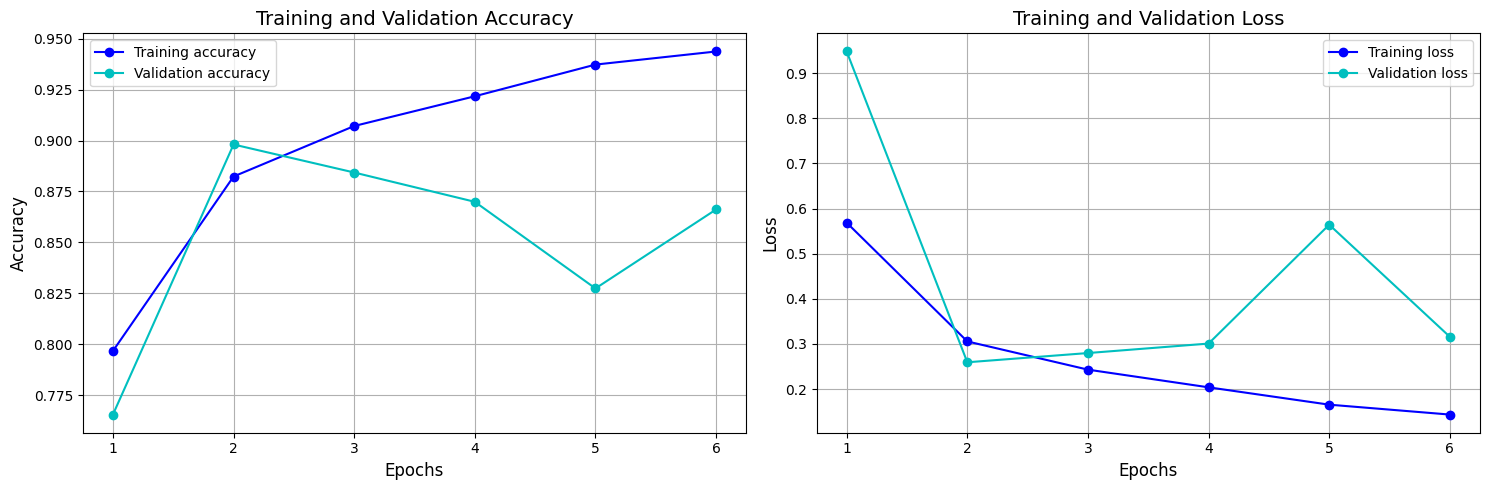

In [16]:
show_history_plot(history_EN3.history)

In [33]:
evaluation_matrix(EN3_model)

             Loss       Accuracy  
----------------------------------
Train        0.22318    0.90500   
Validation   0.31578    0.86617   
Test         0.30716    0.87187   


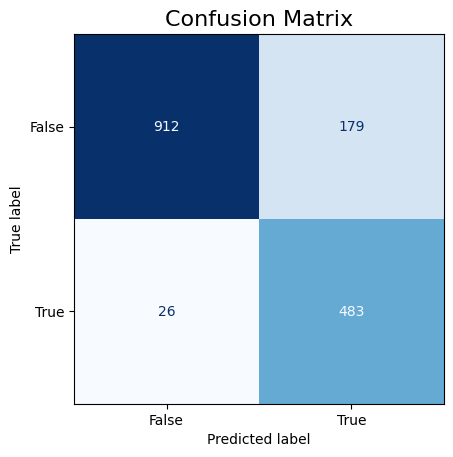

<Figure size 700x700 with 0 Axes>

In [20]:
show_conf_matrix(EN3_model)

In [32]:
# Save the model
EN3_model.save('Leukemia_effecientnetb3.h5')


In [31]:
EN3_model.save("model.h5")

In [ ]:
/kaggle/working/Leukemia_effecientnetb3.h5